In [30]:
library(R.matlab)
library(fda)
library(caTools)
library(gdpc)
library(repr)
#library(MASS)

In [31]:
# Change plot size to 5 x 4
options(repr.plot.width=5, repr.plot.height=4)

In [3]:
# Utility function to get the factors from models
get_factors <- function(model, num_epochs=300) {
    factors_list = list()
    for (epoch in 1:num_epochs) {
        factor = model[, epoch]$f
        factor = (factor - mean(factor)) / sd(factor)
        factors_list[[epoch]] = factor
    }
    res <- do.call(cbind, factors_list)
    return(res)
}

# Utilitiy function to get MSE from models
get_mse <- function(model, num_epochs=300) {
    mse_list = list()
    for (epoch in 1:num_epochs) {
        mse = model[, epoch]$mse
        mse_list[[epoch]] = mse
    }
    return(mse_list)
}

In [4]:
# Collect log periodograms of factors for each epoch
log_periodograms <- function(factors, num_epochs, smooth=TRUE, window=11, tlim=500) {
    
    # Smooth the log periodograms
    smoothing <- function(log_pds, w=window) {
        sm_log_pd_list = list()
        for(i in 1:num_epochs) {
            sm_log_pd = stats::filter(log_pds[[i]], rep(1/w, w), circular=TRUE)
            sm_log_pd_list[[i]] = sm_log_pd
        }
        res <- do.call(cbind, sm_log_pd_list)
        return (res)
    }
    
    logpd.list = c()
    for (i in 1:num_epochs) {
        factor_epoch = factors[, i]
        periodogram = (abs(fft(factor_epoch)))^2
        log_pd = log(periodogram[1:tlim])
        logpd.list[[i]] = log_pd
    }
    if (smooth) {
        res <- smoothing(logpd.list)
    }
    else {
        res <- do.call(cbind, logpd.list)
    }
    return (res)
}

In [50]:
plot_factors <- function(GDPC, SPCA, epoch) {
    ulim = max(max(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    llim = min(min(SPCA[5:995, epoch], GDPC[5:995, epoch]))
    par(mar=c(6.1, .5, 2.1, 6.1), xpd=TRUE)
    plot(GDPC[5:995, epoch], xaxt="n", yaxt="n", type='l', ylab='',ylim=c(llim, ulim),
         main=sprintf("First Factors: Epoch %s", epoch),xlab='ms', bty="n", col="darkblue")
    lines(SPCA[5:995, epoch], col=2, xpd=FALSE)
    axis(side=1, at=seq(0, 1000, 1000))
    par(xpd=TRUE)
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-0.3, 0), text.font=2)
}

plot_periodograms <-function(Xgpd, Xspd, epoch) {
    ulim = max(max(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    llim = min(min(Xspd[7:495, epoch], Xgpd[7:495, epoch]))
    par(mar=c(6.1, 0.5, 4.1, 4.1), xpd=TRUE)
    plot(Xspd[7:495, epoch], xaxt="n", yaxt="n", type='l', ylab='', xlab='Hz',ylim=c(llim, ulim),
         main=sprintf("Log Periodograms: Epoch %s", epoch), bty='n', col='red')
    lines(Xgpd[7:495, epoch], col="darkblue", xpd=FALSE)
    axis(side=1, at=seq(0, 500, 500))
    legend("topright", ex.cs1, cex=0.9, y.intersp=2.5,legend=c("GDPCA", "SPCA"), bty="n", 
           lty=c(1,1),col=c("darkblue", "red"), inset=c(-.17, 0), text.font=2)
}

plot_periodograms2 <-function(Xgpd, lag1, Xgpd2, lag2, Xspd, epoch) {
    ulim = max(max(Xspd[7:495, epoch]), max(Xgpd[7:495, epoch]), max(Xgpd2[7:495, epoch]))
    llim = min(min(Xspd[7:495, epoch]), min(Xgpd[7:495, epoch]), min(Xgpd2[7:495, epoch]))
    par(mar=c(6.1, 0.5, 4.1, 10.1), xpd=TRUE)
    plot(Xspd[7:495, epoch], xaxt="n", yaxt="n", type='l', ylab='', xlab='Hz',ylim=c(llim, ulim),
         main=sprintf("Log Periodograms: Epoch %s", epoch), bty='n', col='red')
    lines(Xgpd[7:495, epoch], col="darkblue", xpd=FALSE)
    lines(Xgpd2[7:495, epoch], col="darkgreen", xpd=FALSE)
    axis(side=1, at=seq(0, 500, 500))
    gtitle1 = sprintf("GDPCA lag %s", lag1)
    gtitle2 = sprintf("GDPCA lag %s", lag2)
    stitle = "SPCA"
    legend("topright", ex.cs1, cex=0.9, y.intersp=1.7,legend=c(gtitle1, gtitle2, stitle),
           bty="n", lty=c(1,1,1),col=c("darkblue", "darkgreen", "red"), inset=c(-.38, 0), text.font=2)
}

In [35]:
# Functions to save factors and log periodograms
save_factor_plots <- function(G, S, epochs, subdir="lagx_factors") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_factors(G, S, i)
        dev.off()
    }
}

save_logp_plots <- function(G, S, epochs, subdir="lagx_logp") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_periodograms(G, S, i)
        dev.off()
    }
}

save_logp_plots2 <- function(G1, lag1, G2, lag2, S, epochs, subdir="lagx_logp") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=7, height=5, units="in", res=600)
        plot_periodograms2(G1, lag1, G2, lag2, S, i)
        dev.off()
    }
}

In [7]:
plot_pre_lfp_factor <- function(lfp, G, S, epoch, legend, with_gdpc=TRUE, with_spca=TRUE) {
    exs = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)

    par(mar=c(6.1, 0.5, 4.1, 6.5), xpd=TRUE)
    start = (epoch-1)*1000+1
    end = epoch*1000
    ulim = max(max(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    llim = min(min(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", ylim=c(llim, ulim),
                  bty="n", main=sprintf("LFPs: Epoch %s", epoch), xpd=FALSE)
    ts.plot(lfp[(start+5):(end-5), exs], gpars=params)
    if (with_gdpc) {
        lines(G[5:995,epoch], col='red', lwd=2)
    }
    if (with_spca){
        lines(S[5:995,epoch], col='orange', lwd=2)
    }
    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5, legend=legend, bty="n", 
           lty=c(1,1),col=c("red", "orange"), inset=c(-0.3, 0))
}

plot_pre_lfp_factor2 <- function(lfp, G, G2, S, epoch, legend) {
    exs = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)

    par(mar=c(6.1, 0.5, 4.1, 6.7), xpd=TRUE)
    start = (epoch-1)*1000+1
    end = epoch*1000
    ulim = max(max(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    llim = min(min(G[5:995, epoch], lfp[(start+5):(end-5), exs]))
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", ylim=c(llim, ulim),
                  bty="n", main=sprintf("LFPs: Epoch %s", epoch), xpd=FALSE)
    ts.plot(lfp[(start+5):(end-5), exs], gpars=params)
    lines(G[5:995,epoch], col='red', lwd=2)
    lines(G2[5:995,epoch], col='chartreuse4', lwd=2)
    lines(S[5:995,epoch], col='orange', lwd=1.7)
    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5, legend=legend, bty="n", 
           lty=c(1,1),col=c("red", "chartreuse4", "orange"), inset=c(-0.17, 0))
}

In [8]:
normalize_pre <- function(data, epochs=c(1:300)) {
    Z = data
    excludes = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)
    for (i in epochs) {
        Zepoch = Z[((i-1)*1000+1):(i*1000), excludes]
        Z[((i-1)*1000+1):(i*1000), excludes] = (Zepoch - mean(Zepoch)) / sd(Zepoch)
    }
    return(Z)
}

In [33]:
# Functions to save factors superimposed with lfp
save_lfp_factors <- function(Z, G, S, epochs, legend, subdir="lagx_lfp_gfactor", gdpc=TRUE, spca=FALSE) {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_post_lfp_factor(Z, G, S, i, legend=legend, with_gdpc=gdpc, with_spca=spca)
        dev.off()
    }
}

# Functions to save factors superimposed with lfp
save_lfp_factors2 <- function(Z, G, G2, S, epochs, legend, subdir="lagx_lagy_lfp_gsfactor") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=6, height=5, units="in", res=600)
        plot_pre_lfp_factor2(Z, G, G2, S, i, legend=legend)
        dev.off()
    }
}

In [10]:
recons_gdpc_epoch <- function(model, epoch) {
    out <- model[, epoch]
    class(out) <- append(class(out), "gdpc")
    recons <- fitted(out, epoch)
    return(recons)
}

plot_pre_lfp_recons <- function(Z, G, model, epoch, legend) {
    exs = c(1:5, 7:8, 11:12, 14:16, 18:26, 28:32)    
    start = (epoch-1)*1000+1
    end = epoch*1000
    ts_z = Z[start:end, exs]
    G_r = recons_gdpc_epoch(model, epoch)
    ts_g_r = G_r / sd(G_r)
    
    par(mar=c(6.1, 0.5, 4.1, 6.7), xpd=TRUE)
    ulim = max(max(ts_g_r, ts_z))
    llim = min(min(ts_g_r, ts_z))
    params = list(yaxt="n", xaxt="n", ylab="", xlab="ms", ylim=c(llim, ulim),
                  bty="n", main=sprintf("Reconstruction: Epoch %s", epoch), xpd=FALSE)

    ts.plot(ts_z, gpars=params)
    chs = ncol(ts_g_r)
    for (i in 1:chs) {
        lines(ts_g_r[, i], col="darkgreen", lty='dashed')
    }
    axis(side=1, at=seq(0, 1000, 1000))
    legend("topright", ex.cs1, cex=0.6, y.intersp=2.5, legend=legend, bty="n", 
           lty=c(2,1),col=c("darkgreen", "black"), inset=c(-0.3, 0))
}

In [11]:
# Functions to save reconstructions using gdpca
save_grecons <- function(Z, G, model, epochs, legend, subdir="lagx_grecon") {
    pardir =  "."
    if (!dir.exists(file.path(pardir, subdir))) {
        dir.create(file.path(pardir, subdir))
    }

    for (i in epochs) {
        png(filename=sprintf("%s/%s_epoch%s.png", subdir, subdir, i),
            width=5, height=5, units="in", res=600)
        plot_pre_lfp_recons(Z, G, model, i, legend=legend)
        dev.off()
    }
}

In [12]:
# Read data
pre_lag1 <- source('data/pre/models_1.Rdmpd')
pre_lag10 <- source('data/pre/models_10.Rdmpd')
pre_lag15 <- source('data/pre/models_15.Rdmpd')
pre_lag20 <- source('data/pre/models_20.Rdmpd')
pre_lag50 <- source('data/pre/models_50.Rdmpd')
pre_lag150 <- source('data/pre/models_150.Rdmpd')
pre_lag299 <- source('data/pre/models_299.Rdmpd')
pre_lag500 <- source('data/pre/models_500.Rdmpd')
pre_lag700 <- source('data/pre/models_700.Rdmpd')
pre_lag999 <- source('data/pre/models_999.Rdmpd')

# Get models for lags: 10, 150, 299, 500, 700, 999
model1 = pre_lag1[[1]]
model10 = pre_lag10[[1]]
model15 = pre_lag15[[1]]
model20 = pre_lag20[[1]]
model50 = pre_lag50[[1]]
model150 = pre_lag150[[1]]
model299 = pre_lag299[[1]]
model500 = pre_lag500[[1]]
model700 = pre_lag700[[1]]
model999 = pre_lag999[[1]]

In [13]:
# Get pre factors for GDPCA
G1 = get_factors(model1)
G10 = get_factors(model10)
G15 = get_factors(model15)
G20 = get_factors(model20)
G50 = get_factors(model50)
G150 = get_factors(model150)
G299 = get_factors(model299)
G500 = get_factors(model500)
G700 = get_factors(model700)
G999 = get_factors(model999)

# Get mse for GDPCA
mse1 = get_mse(model1)
mse10 = get_mse(model10)
mse15 = get_mse(model15)
mse20 = get_mse(model20)
mse50 = get_mse(model50)
mse150 = get_mse(model150)
mse299 = get_mse(model299)
mse500 = get_mse(model500)
mse700 = get_mse(model700)
mse999 = get_mse(model999)

# Read post factors for SPCA
S = as.matrix(read.csv("data/pre/factor1_pre_normalized_removed.csv"))[, 2:1001]

# Take transpose of SPCA for functional boxplots
S = t(S)

In [14]:
# Get log periodograms for SPCA and GDPC
P_s = log_periodograms(S, num_epochs=300)
P_g1 = log_periodograms(G1, num_epochs=300, smooth=FALSE)
P_g10 = log_periodograms(G10, num_epochs=300, smooth=FALSE)
P_g15 = log_periodograms(G15, num_epochs=300, smooth=FALSE)
P_g20 = log_periodograms(G20, num_epochs=300, smooth=FALSE)
P_g50 = log_periodograms(G50, num_epochs=300, smooth=FALSE)
P_g150 = log_periodograms(G150, num_epochs=300, smooth=FALSE)
P_g299 = log_periodograms(G299, num_epochs=300, smooth=FALSE)
P_g500 = log_periodograms(G500, num_epochs=300, smooth=FALSE)
P_g700 = log_periodograms(G700, num_epochs=300, smooth=FALSE)
P_g999 = log_periodograms(G999, num_epochs=300, smooth=FALSE)

In [15]:
# Read in pre_pmcao data
data = readMat('data/F141020-lfp-5min-1kHz.mat')
Zpre = data$pre.pmcao

In [16]:
# Normalize data set
Z_norm = normalize_pre(Zpre)

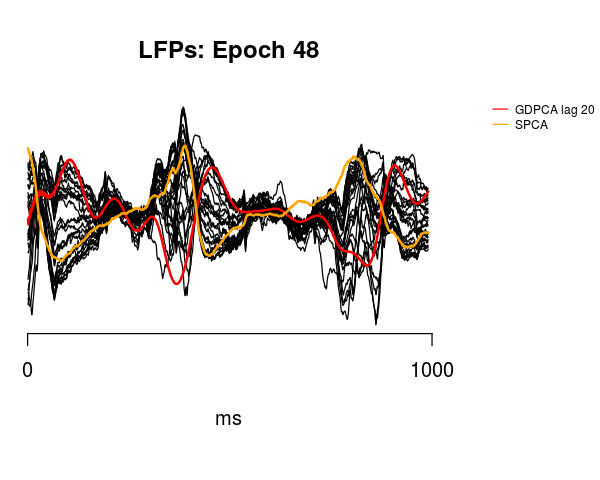

In [17]:
plot_pre_lfp_factor(Z_norm, G10, S, 48, legend=c("GDPCA lag 20", "SPCA"))

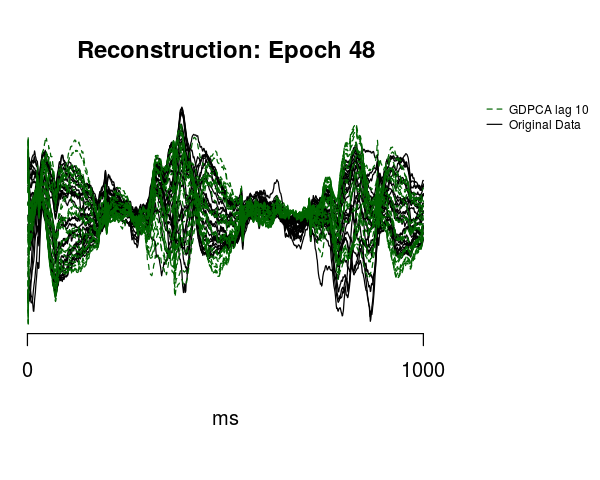

In [18]:
plot_pre_lfp_recons(Z_norm, G10, model10, epoch=48, legend=c("GDPCA lag 10", "Original Data"))

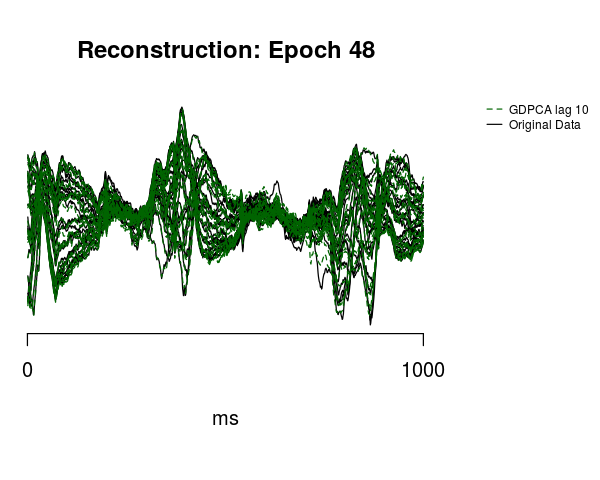

In [19]:
plot_pre_lfp_recons(Z_norm, G500, model500, epoch=48, legend=c("GDPCA lag 10", "Original Data"))

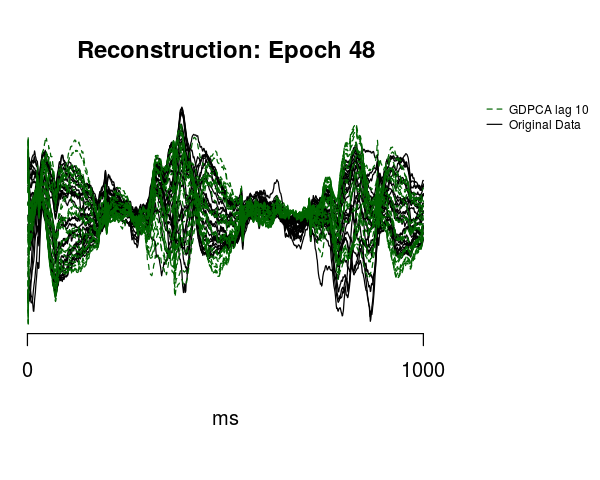

In [20]:
ts10 = plot_pre_lfp_recons(Z_norm, G10, model10, epoch=48, legend=c("GDPCA lag 10", "Original Data"))

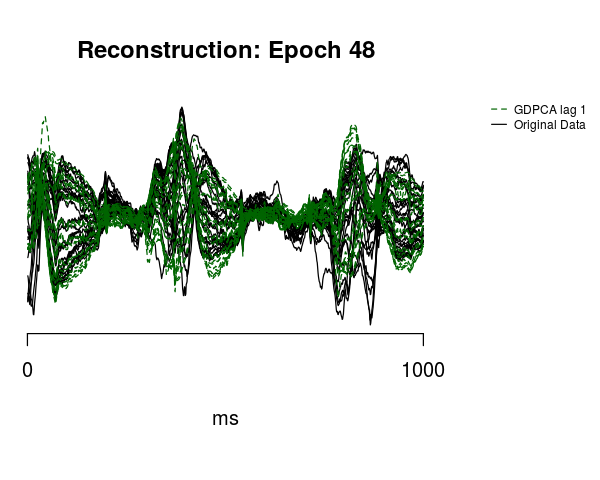

In [21]:
plot_pre_lfp_recons(Z_norm, G1, model1, epoch=48, legend=c("GDPCA lag 1", "Original Data"))

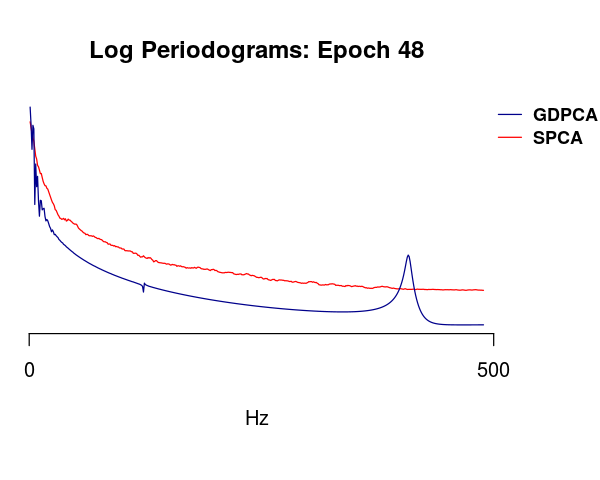

In [22]:
plot_periodograms(P_g10, P_s, 48)

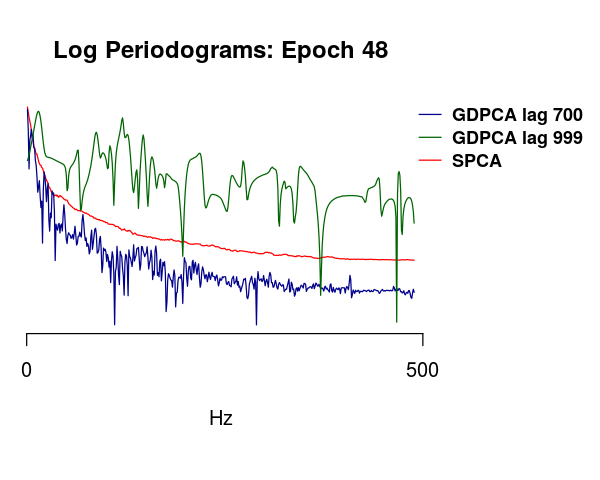

In [32]:
plot_periodograms2(P_g700, lag1=700, P_g999, lag2=999, P_s, 48)

In [51]:
#epochs = c(1:300)
epochs = c(4, 48, 49, 68, 145, 153, 220, 244, 287, 300)

save_logp_plots2(P_g1, lag1=1, P_g10, lag2=10, P_s, epochs, subdir="lag1_lag_10_logp")
save_logp_plots2(P_g15, lag1=15, P_g20, lag2=20, P_s, epochs, subdir="lag15_lag_20_logp")
save_logp_plots2(P_g50, lag1=50, P_g150, lag2=150, P_s, epochs, subdir="lag50_lag_150_logp")
save_logp_plots2(P_g299, lag1=299, P_g500, lag2=500, P_s, epochs, subdir="lag299_lag_500_logp")
save_logp_plots2(P_g700, lag1=700, P_g999, lag2=999, P_s, epochs, subdir="lag700_lag_999_logp")

save_grecons(Z_norm, G1, model1, epochs, legend=c("GDPC lag 1", "Original Data"), subdir="lag1_grecon")
save_grecons(Z_norm, G10, model10, epochs, legend=c("GDPC lag 10", "Original Data"), subdir="lag10_grecon")
save_grecons(Z_norm, G15, model15, epochs, legend=c("GDPC lag 15", "Original Data"), subdir="lag15_grecon")
save_grecons(Z_norm, G20, model20, epochs, legend=c("GDPC lag 20", "Original Data"), subdir="lag20_grecon")
save_grecons(Z_norm, G50, model50, epochs, legend=c("GDPC lag 50", "Original Data"), subdir="lag50_grecon")
save_grecons(Z_norm, G150, model150, epochs, legend=c("GDPC lag 150", "Original Data"), subdir="lag150_grecon")
save_grecons(Z_norm, G299, model299, epochs, legend=c("GDPC lag 299", "Original Data"), subdir="lag299_grecon")
save_grecons(Z_norm, G500, model500, epochs, legend=c("GDPC lag 500", "Original Data"), subdir="lag500_grecon")
save_grecons(Z_norm, G700, model700, epochs, legend=c("GDPC lag 700", "Original Data"), subdir="lag700_grecon")
save_grecons(Z_norm, G999, model999, epochs, legend=c("GDPC lag 999", "Original Data"), subdir="lag999_grecon")

In [53]:
# #epochs = c(1:300)
# epochs = c(4, 48, 49, 68, 145, 153, 220, 244, 287, 300)

# leg1 = legend=c("GDPCA lag 1", "GDPCA lag 10", "SPCA")
# save_lfp_factors2(Z_norm, G1, G10, S, epochs, legend=leg1, subdir="lag1_lag10_lfp_g2sfactor")

# leg2 = legend=c("GDPCA lag 15", "GDPCA lag 20", "SPCA")
# save_lfp_factors2(Z_norm, G15, G20, S, epochs, legend=leg2, subdir="lag15_lag20_lfp_g2sfactor")

# leg3 = legend=c("GDPCA lag 50", "GDPCA lag 150", "SPCA")
# save_lfp_factors2(Z_norm, G50, G150, S, epochs, legend=leg3, subdir="lag50_lag150_lfp_g2sfactor")

# leg4 = legend=c("GDPCA lag 299", "GDPCA lag 500", "SPCA")
# save_lfp_factors2(Z_norm, G299, G500, S, epochs, legend=leg4, subdir="lag299_lag500_lfp_g2sfactor")

# leg5 = legend=c("GDPCA lag 700", "GDPCA lag 999", "SPCA")
# save_lfp_factors2(Z_norm, G700, G999, S, epochs, legend=leg5, subdir="lag700_lag999_lfp_g2sfactor")

In [ ]:
# TODO: Make this code into function for video!

# ulim = max(max(P_s[7:495, ]), max(P_g299[7:495, ]))
# llim = min(min(P_s[7:495, ]), min(P_g299[7:495, ]))
# for(i in 1:300) {

#     png(filename = sprintf("pre_frames_299/%s.png", i), width=7, height=4, units='in', res=300)
#     par(mfrow = c(1, 2))
#     plot(P_s[7:495, i], xaxt="n", yaxt="n", type='l', ylab='', ylim=c(llim, ulim),
#     main=sprintf("SPCA Epoch %s", i),xlab='Hz', bty="n", col="black")
#     axis(side=1, at=seq(0, 500, 500))
    
#     for(j in 1:i) {
#         lines(P_s[7:495, j], col = "black")
#     }
#     lines(P_s[7:495, i], col = "red", lwd = 2)
    
#     plot(P_g299[7:495, i], xaxt="n", yaxt="n", type='l', ylab='', ylim=c(llim, ulim),
#     main=sprintf("GDPCA Lag 299 Epoch %s", i),xlab='Hz', bty="n", col="black")
#     axis(side=1, at=seq(0, 500, 500))
    
#     for(j in 1:i) {
#         lines(P_g299[7:495, j], col = "black")
#     }
#     lines(P_g299[7:495, i], col = "red", lwd = 2)
#     dev.off()
# }

In [ ]:
# # Save log periodograms
# #epochs = c(1:300)
# epochs = c(4, 48, 49, 68, 145, 153, 220, 244, 287, 300)

# save_logp_plots(P_g1, P_s, epochs, subdir="lag1_logp")
# save_logp_plots(P_g10, P_s, epochs, subdir="lag10_logp")
# save_logp_plots(P_g15, P_s, epochs, subdir="lag15_logp")
# save_logp_plots(P_g20, P_s, epochs, subdir="lag20_logp")
# save_logp_plots(P_g50, P_s, epochs, subdir="lag50_logp")
# save_logp_plots(P_g150, P_s, epochs, subdir="lag150_logp")
# save_logp_plots(P_g299, P_s, epochs, subdir="lag299_logp")
# save_logp_plots(P_g500, P_s, epochs, subdir="lag500_logp")
# save_logp_plots(P_g700, P_s, epochs, subdir="lag700_logp")
# save_logp_plots(P_g999, P_s, epochs, subdir="lag999_logp")

In [56]:
#png(filename = "pre_gdpca_functional_lag1.png", width=5, height=5, units="in", res=600)
P_g1[P_g1 == -Inf] = 0
llim = min(P_g1[5:495,])
ulim = max(P_g1[5:495,])
fbg_1 = fbplot(P_g1[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 1", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [57]:
#png(filename = "pre_gdpca_functional_lag10.png", width=5, height=5, units="in", res=600)
P_g10[P_g10 == -Inf] = 0
llim = min(P_g10[5:495,])
ulim = max(P_g10[5:495,])
fbg_10 = fbplot(P_g10[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 10", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [58]:
#png(filename = "pre_gdpca_functional_lag15.png", width=5, height=5, units="in", res=600)
P_g15[P_g15 == -Inf] = 0
llim = min(P_g15[5:495,])
ulim = max(P_g15[5:495,])
fbg_15 = fbplot(P_g15[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 15", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [59]:
#png(filename = "pre_gdpca_functional_lag20.png", width=5, height=5, units="in", res=600)
P_g20[P_g20 == -Inf] = 0
llim = min(P_g20[5:495,])
ulim = max(P_g20[5:495,])
fbg_20 = fbplot(P_g20[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 20", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [60]:
#png(filename = "pre_gdpca_functional_lag50.png", width=5, height=5, units="in", res=600)
P_g50[P_g50 == -Inf] = 0
llim = min(P_g50[5:495,])
ulim = max(P_g50[5:495,])
fbg_50 = fbplot(P_g50[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 50", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [61]:
#png(filename = "pre_gdpca_functional_lag150.png", width=5, height=5, units="in", res=600)
P_g150[P_g150 == -Inf] = 0
llim = min(P_g150[5:495,])
ulim = max(P_g150[5:495,])
fb_g150 = fbplot(P_g150[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 150", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [62]:
#png(filename = "pre_gdpca_functional_lag299.png", width=5, height=5, units="in", res=600)
P_g299[P_g299 == -Inf] = 0
llim = min(P_g299[5:495,])
ulim = max(P_g299[5:495,])
fbg_299 = fbplot(P_g299[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 299", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [63]:
#png(filename = "pre_gdpca_functional_lag500.png", width=5, height=5, units="in", res=600)
P_g500[P_g500 == -Inf] = 0
llim = min(P_g500[5:495,])
ulim = max(P_g500[5:495,])
fbg_500 = fbplot(P_g500[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 500", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [92]:
#png(filename = "pre_gdpca_functional_lag700.png", width=5, height=5, units="in", res=600)
P_g700[P_g700 == -Inf] = 0
llim = min(P_g700[5:495,])
ulim = max(P_g700[5:495,])
fbg_700 = fbplot(P_g700[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 700", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

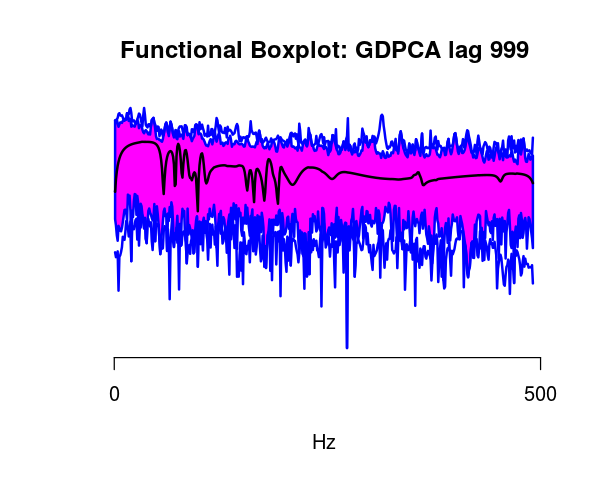

In [98]:
#png(filename = "pre_gdpca_functional_lag999.png", width=5, height=5, units="in", res=600)
P_g999[P_g999 == -Inf] = 0
llim = min(P_g999[5:495,])
ulim = max(P_g999[5:495,])
fbg_999 = fbplot(P_g999[5:495,],method='MBD',ylab="",xlab="Hz", main = "Functional Boxplot: GDPCA lag 999", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

In [65]:
#png(filename = "pre_spca_functional.png", width=5, height=5, units="in", res=600)
P_s[P_s == -Inf] = 0
llim = min(P_s[5:495,])
ulim = max(P_s[5:495,])
spca_fb = fbplot(P_s[5:495,],method='MBD',ylab="",xlab="Hz", main = "SPCA - Functional Boxplot", 
                 ylim=c(llim, ulim),  xaxt="n", yaxt="n", bty = "n")
axis(side=1, at=seq(0, 500, 500))
#dev.off()

png 
  2

In [116]:
#png(filename = "pre_medians_lag1_lag10.png", width=7, height=5, units="in", res=600)

#Extracting the median curve for SPCA periodograms
par(mar=c(6.1, 0.3, 6.1, 10.1), xpd=TRUE)

spca_post_med = spca_fb$medcurve
gpca_post_med1 = fbg_1$medcurve
gpca_post_med10 = fbg_10$medcurve

llim = min(min(P_s[5:495,spca_post_med]), min(P_g1[5:495, gpca_post_med1]), min(min(P_g10[5:495, gpca_post_med10])))
ulim = max(max(P_s[5:495,spca_post_med], P_g1[5:495, gpca_post_med1]))

plot(P_s[5:495,spca_post_med], xaxt="n", yaxt="n", bty = "n", col = "red", xlab = "Hz",
     lwd = 2, main = "Median curves", ylab = "", type = 'l', cex.main=1, ylim=c(llim, ulim))
axis(side=1, at=seq(0, 500, 500))

lines(P_g1[5:495, gpca_post_med1], col = "blue", lwd=2)
lines(P_g10[5:495, gpca_post_med10], col = "darkorange", lwd=2)

legend("topright", ex.cs1, cex=1, y.intersp=3.5,legend=c("GDPCA lag 1", "GDPCA lag 10", "SPCA"), bty="n", 
       lty=c(1,1,1),col=c("darkblue", "darkorange", "red"), inset=c(-0.4, 0), text.font=1, pt.cex=1)
#dev.off()

png 
  2

In [117]:
#png(filename = "pre_medians_lag15_lag20.png", width=7, height=5, units="in", res=600)

#Extracting the median curve for SPCA periodograms
par(mar=c(6.1, 0.3, 6.1, 10.1), xpd=TRUE)

spca_post_med = spca_fb$medcurve
gpca_post_med15 = fbg_15$medcurve
gpca_post_med20 = fbg_20$medcurve

llim = min(min(P_s[5:495,spca_post_med]), min(P_g15[5:495, gpca_post_med15]), min(P_g20[5:495, gpca_post_med20]))
ulim = max(max(P_s[5:495,spca_post_med]), max(P_g15[5:495, gpca_post_med15]), max(P_g20[5:495, gpca_post_med20]))

plot(P_s[5:495,spca_post_med], xaxt="n", yaxt="n", bty = "n", col = "red", xlab = "Hz",
     lwd = 2, main = "Median curves", ylab = "", type = 'l', cex.main=1, ylim=c(llim, ulim))
axis(side=1, at=seq(0, 500, 500))

lines(P_g15[5:495, gpca_post_med15], col = "darkblue", lwd=2)
lines(P_g20[5:495, gpca_post_med20], col = "darkorange", lwd=2)

legend("topright", ex.cs1, cex=1, y.intersp=3.5,legend=c("GDPCA lag 15", "GDPCA lag 20", "SPCA"), bty="n", 
       lty=c(1,1,1),col=c("darkblue", "darkorange", "red"), inset=c(-0.4, 0), text.font=1, pt.cex=1)
#dev.off()

png 
  2

In [118]:
#png(filename = "pre_medians_lag50_lag150.png", width=7, height=5, units="in", res=600)

#Extracting the median curve for SPCA periodograms
par(mar=c(6.1, 0.3, 6.1, 10.1), xpd=TRUE)

spca_post_med = spca_fb$medcurve
gpca_post_med50 = fbg_50$medcurve
gpca_post_med150 = fb_g150$medcurve

llim = min(min(P_s[5:495,spca_post_med]), min(P_g50[5:495, gpca_post_med50]), min(P_g150[5:495, gpca_post_med150]))
ulim = max(max(P_s[5:495,spca_post_med]), max(P_g50[5:495, gpca_post_med50]), max(P_g150[5:495, gpca_post_med150]))

plot(P_s[5:495,spca_post_med], xaxt="n", yaxt="n", bty = "n", col = "red", xlab = "Hz",
     lwd = 2, main = "Median curves", ylab = "", type = 'l', cex.main=1, ylim=c(llim, ulim))
axis(side=1, at=seq(0, 500, 500))

lines(P_g50[5:495, gpca_post_med50], col = "darkblue", lwd=2)
lines(P_g150[5:495, gpca_post_med150], col = "darkorange", lwd=2)

legend("topright", ex.cs1, cex=1, y.intersp=3.5,legend=c("GDPCA lag 50", "GDPCA lag 150", "SPCA"), bty="n", 
       lty=c(1,1,1),col=c("darkblue", "darkorange", "red"), inset=c(-0.4, 0), text.font=1, pt.cex=1)
#dev.off()

png 
  2

In [119]:
#png(filename = "pre_medians_lag299_lag500.png", width=7, height=5, units="in", res=600)

#Extracting the median curve for SPCA periodograms
par(mar=c(6.1, 0.3, 6.1, 10.1), xpd=TRUE)

spca_post_med = spca_fb$medcurve
gpca_post_med299 = fbg_299$medcurve
gpca_post_med500 = fbg_500$medcurve


llim = min(min(P_s[5:495,spca_post_med]), min(P_g299[5:495, gpca_post_med299]), min(P_g299[5:495, gpca_post_med299])) -1
ulim = max(max(P_s[5:495,spca_post_med]), max(P_g299[5:495, gpca_post_med299]), max(P_g500[5:495, gpca_post_med500]))

plot(P_s[5:495,spca_post_med], xaxt="n", yaxt="n", bty = "n", col = "red", xlab = "Hz",
     lwd = 2, main = "Median curves", ylab = "", type = 'l', cex.main=1, ylim=c(llim, ulim))
axis(side=1, at=seq(0, 500, 500))

lines(P_g299[5:495, gpca_post_med299], col = "darkblue", lwd=2)
lines(P_g500[5:495, gpca_post_med500], col = "darkorange", lwd=2)

legend("topright", ex.cs1, cex=1, y.intersp=3.5,legend=c("GDPCA lag 299", "GDPCA lag 500", "SPCA"), bty="n", 
       lty=c(1,1,1),col=c("darkblue", "darkorange", "red"), inset=c(-0.4, 0), text.font=1, pt.cex=1)
#dev.off()

png 
  2

In [120]:
#png(filename = "pre_medians_lag700_lag999.png", width=7, height=5, units="in", res=600)

#Extracting the median curve for SPCA periodograms
par(mar=c(6.1, 0.3, 6.1, 10.1), xpd=TRUE)

spca_post_med = spca_fb$medcurve
gpca_post_med700 = fbg_700$medcurve
gpca_post_med999 = fbg_999$medcurve

llim = min(min(P_s[5:495,spca_post_med]), min(P_g700[5:495, gpca_post_med700]), min(P_g999[5:495, gpca_post_med999]))
ulim = max(max(P_s[5:495,spca_post_med]), max(P_g700[5:495, gpca_post_med700]), max(P_g999[5:495, gpca_post_med999]))

plot(P_s[5:495,spca_post_med], xaxt="n", yaxt="n", bty = "n", col = "red", xlab = "Hz",
     lwd = 2, main = "Median curves", ylab = "", type = 'l', cex.main=1, ylim=c(llim, ulim))
axis(side=1, at=seq(0, 500, 500))

lines(P_g700[5:495, gpca_post_med700], col = "darkblue", lwd=2)
lines(P_g999[5:495, gpca_post_med999], col = "darkorange", lwd=2)

legend("topright", ex.cs1, cex=1, y.intersp=3.5,legend=c("GDPCA lag 700", "GDPCA lag 999", "SPCA"), bty="n", 
       lty=c(1,1,1),col=c("darkblue", "darkorange", "red"), inset=c(-0.4, 0), text.font=1, pt.cex=1)
#dev.off()

png 
  2

In [122]:
my_mse = c(mean(as.numeric(mse1)), mean(as.numeric(mse10)), mean(as.numeric(mse15)), 
           mean(as.numeric(mse20)), mean(as.numeric(mse50)), mean(as.numeric(mse150)),
           mean(as.numeric(mse299)), mean(as.numeric(mse500)), mean(as.numeric(mse700)), mean(as.numeric(mse999)))

In [123]:
my_mse

[1] 64199.44292 50470.64378 49298.14045 48237.91869 43458.44177 29786.71011
 [7] 15830.84299  6161.28217  2045.05319     1.67188

In [125]:
#png(filename = "pre_gdpca_mse.png", width=5, height=5, units="in", res=600)
plot(my_mse, xaxt="n", yaxt="n", ylab='', type = 'l', bty="n",
     main="Average Epoch MSE: GDPCA", xlab='Lag', col="darkblue")
axis(side=1, at=seq(1, 10, 9), labels = c(1, 999))
#dev.off()

png 
  2